In [49]:
import pandas as pd
import numpy as np
import os
import re
import math
from concurrent.futures import ThreadPoolExecutor

In [50]:
DIR = "./data/"
folders = list(filter(lambda file: not file.endswith(".tgz"), os.listdir(DIR)))[:2]

In [51]:
folders

['1028-20100710-hne', '1337ad-20170321-ajg']

In [52]:
def load_labels(folders):
    def helper(folder):
        try:
            file_path = os.path.join(DIR, folder, "etc", "README")
            with open(file_path, "r") as file:
                lines = [line for line in file.readlines() if "gender" in line.lower()]
                file.close()

            # print(lines)

            # extract only the gender of the subject in meta data
            # print(lines[0].lower())
            string = re.search(r"(male|female|weiblich|männlich|unknown)", lines[0].lower())
            # print(string)
            if string:
                gender = string[0]
                if (gender == "male" or gender == "männlich"):
                    return folder, "male"
                elif (gender == "female" or gender == "weiblich"):
                    return folder, "female"
                else:
                    return folder, "unknown"
            
        except IndexError:
            return folder, "unknown"
        
        except FileNotFoundError:
            return folder, "unknown"

    with ThreadPoolExecutor() as exe:
        subjects_labels = list(exe.map(helper, folders))
        
        
    return subjects_labels

In [53]:
labels = load_labels(folders)
labels

[('1028-20100710-hne', 'male'), ('1337ad-20170321-ajg', 'female')]

In [54]:
len(labels)

2

In [55]:
labels_df = pd.DataFrame(labels, columns=["subject_name", "label"])
labels_df

,subject_name,label
0,1028-20100710-hne,male
1,1337ad-20170321-ajg,female


# Once all .tar file contents are extracted we proceed to trimming any insignificant parts of the audio signal and have it be of the same length as the labels

In [56]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.stats import kurtosis as kurt, skew, mode, entropy

In [57]:
def load_audio(DIR: str, folders: list):
    """
    loads audio signals from each .wav file of each subject
    """

    def helper(folder):
    # for folder in folders:
        try:
            wavs_dir = os.path.join(DIR, folder, "wav")
            path_to_wavs = os.listdir(wavs_dir)

        # this is if a .wav file is not used as a directory so 
        # try flac 
        except FileNotFoundError:
            wavs_dir = os.path.join(DIR, folder, "flac")
            path_to_wavs = os.listdir(wavs_dir)

        finally:
            # create storage for list of signals to all be 
            # concatenated later
            ys = []

            # create figure, and axis
            # fig, axes = plt.subplots(nrows=len(path_to_wavs), ncols=1, figsize=(12, 30))
            # fig = plt.figure(figsize=(17, 5))
            for index, wav in enumerate(path_to_wavs):

                wav_path = os.path.join(wavs_dir, wav)
                # print(wav_path)

                # each .wav file has a sampling frequency is 16000 hertz 
                y, sr = librosa.load(wav_path, sr=None)

                # top_db is set to 20 representing any signal below
                # 20 decibels will be considered silence
                y_trimmed, _ = librosa.effects.trim(y, top_db=20)

                # append y to ys 
                ys.append(y_trimmed)

            # concatenate all audio signals into one final signal as 
            # this is all anyway recorded in the voice of the same gender
            final = np.concatenate(ys, axis=0)
            print(f"shape of final signal: {final.shape}")
            # print(f"shape of signal: {y.shape}")
            # print(f"shape of trimmed signal: {y_trimmed.shape}")
            # print(f"sampling rate: {sr}")
            # librosa.display.waveshow(final, alpha=0.5)

            # plt.tight_layout()
            # plt.show()

            return folder, final
        
    # concurrently load .wav files and trim  each .wav files
    # audio signal and combine into one signal for each subject 
    with ThreadPoolExecutor() as exe:
        signals = list(exe.map(helper, folders))
        
    return signals

In [58]:
signals = load_audio(DIR, folders)

shape of final signal: (521216,)
shape of final signal: (568320,)


### Shape of newly combined dataset for each subject will have a longer vector

In [59]:
signals[0]

('1028-20100710-hne',
 array([-0.01312256, -0.01303101, -0.01281738, ...,  0.00253296,
         0.00219727,  0.00201416], dtype=float32))

In [60]:
signals[0][1].shape

(521216,)

In [61]:
len(signals)

2

In [62]:
signals

[('1028-20100710-hne',
  array([-0.01312256, -0.01303101, -0.01281738, ...,  0.00253296,
          0.00219727,  0.00201416], dtype=float32)),
 ('1337ad-20170321-ajg',
  array([-0.01837158, -0.01971436, -0.02127075, ..., -0.00628662,
         -0.00567627, -0.00463867], dtype=float32))]

In [63]:
signals_df = pd.DataFrame(signals, columns=["subject_name", "raw_signals"])
signals_df

,subject_name,raw_signals
0,1028-20100710-hne,"[-0.013122559, -0.013031006, -0.012817383, -0...."
1,1337ad-20170321-ajg,"[-0.018371582, -0.019714355, -0.021270752, -0...."


In [64]:
dataset_df = signals_df.merge(labels_df, how="left", on=["subject_name"])
dataset_df

,subject_name,raw_signals,label
0,1028-20100710-hne,"[-0.013122559, -0.013031006, -0.012817383, -0....",male
1,1337ad-20170321-ajg,"[-0.018371582, -0.019714355, -0.021270752, -0....",female


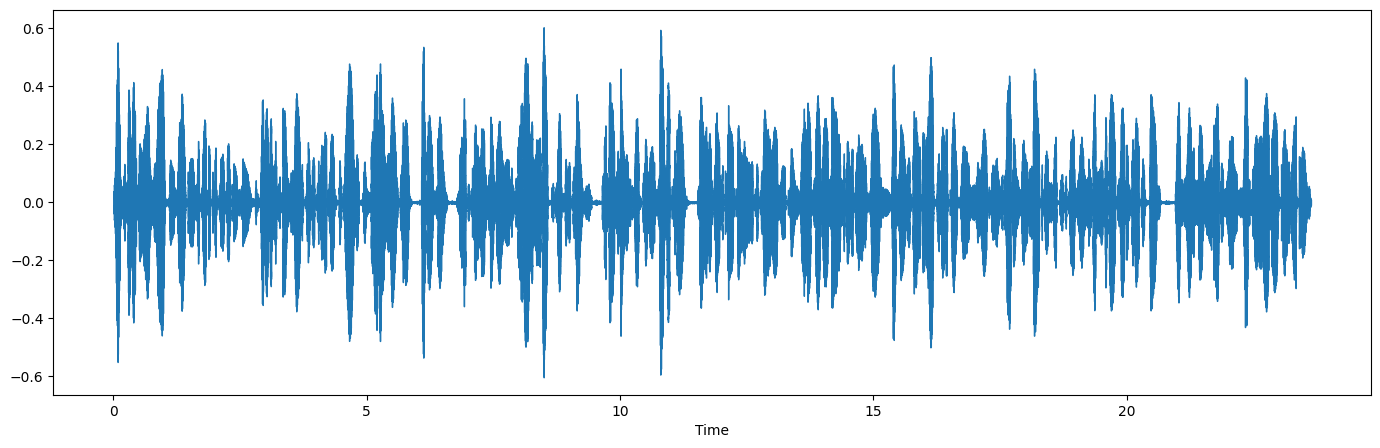

In [65]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(dataset_df.loc[0, "raw_signals"])
plt.show()

In [66]:
dataset = list(dataset_df.itertuples(index=False, name=None))
dataset

[('1028-20100710-hne',
  array([-0.01312256, -0.01303101, -0.01281738, ...,  0.00253296,
          0.00219727,  0.00201416], dtype=float32),
  'male'),
 ('1337ad-20170321-ajg',
  array([-0.01837158, -0.01971436, -0.02127075, ..., -0.00628662,
         -0.00567627, -0.00463867], dtype=float32),
  'female')]

### All we havee to do now is to extract the features of each combined vector for each subject
### 521216 is the length of the 16000hz test audio signal 

In [67]:
def extract_features(dataset: list, hertz: int=16000, window_time: int=3, hop_time: int=1):
    def helper(datum):
        # we access the SCR values via raw data column
        subject_name = datum[0]
        x_signals = datum[1]
        label = datum[2]

        print(subject_name)

        # get number of rows of 16000hz signals 
        n_rows = x_signals.shape[0]
        # print(n_rows)

        # we calculate the window size of each segment or the
        # amount of samples it has to have based on the frequency
        samples_per_win_size = int(window_time * hertz)
        samples_per_hop_size = int(hop_time * hertz)
        # print(samples_per_win_size)
        # print(samples_per_hop_size)

        # initialize segments to empty list as this will store our
        # segmented signals 
        subject_names = []
        segments = []
        labels = []

        

        # this segments our signals into overlapping segments
        for i in range(0, (n_rows - samples_per_win_size) + samples_per_hop_size, samples_per_hop_size):
            # # last segment would have start x: 464000 - end x: 512000
            # # and because 512000 plus our hop size of 16000 = 528000 
            # # already exceeding 521216 this then terminates the loop
            # i += samples_per_hop_size
            # start = i
            # end = i + samples_per_win_size
            start = i
            end = min((i + samples_per_win_size), n_rows)
            # print(f'start x: {start} - end x: {end}')

            # extract segment from calculated start and end
            # indeces
            segment = x_signals[start:end]

            # Calculate the spectrogram
            spectrogram = np.abs(librosa.stft(segment))

            # Get the frequencies corresponding to the spectrogram bins
            frequencies = librosa.fft_frequencies(sr=hertz)

            # Find the frequency bin with the highest average energy
            peak_frequency_bin = np.argmax(np.mean(spectrogram, axis=1))

            # Get the peak frequency in Hz
            peak_frequency = frequencies[peak_frequency_bin]
            
            # calculate statistical features
            mean_freq = np.mean(segment, axis=0)
            median_freq = np.median(segment, axis=0)
            std_freq = np.std(segment, axis=0)
            mode_freq = mode(segment, axis=0)

            # calculate also peak frequency
            # I think dito na gagamit ng fast fourier transform
            # to obtain the frequency, or use some sort of function
            # to convert the raw audio signals into a spectogram
            
            # max = np.max(segment, axis=0)
            # min = np.min(segment, axis=0)

            # calculate first quantile
            # third quantile
            # interquartile range

            # compute morphological features
            skewness = skew(segment)
            kurtosis = kurt(segment)
            features = {
                "mean_freq": mean_freq,
                "median_freq": median_freq,
                "std_freq": std_freq,
                "mode_freq": mode_freq[0],
                "skewness": skewness,
                "kurtosis": kurtosis,
                "peak_frequency": peak_frequency
            }
            
            segments.append(features)

        final = pd.DataFrame.from_records(segments)
        final["label"] = label
        final["subject_name"] = subject_name
        return final

    with ThreadPoolExecutor() as exe: 
        subject_features = list(exe.map(helper, dataset))

    return subject_features

In [68]:
# there are 16000 samples per second
hertz = 16000

# how many seconds we want our window to be
# e.g. if we want our signal segment to be 1 second
# then this would mean 16000 samples that we need to aggregate
window_time = 3

# how many seconds we want our signal segments to overlap
hop_time = 1

In [69]:
subject_features = extract_features(dataset)
subject_features

1028-20100710-hne
1337ad-20170321-ajg


[       mean_freq  median_freq  std_freq  mode_freq  skewness   kurtosis  \
 0   4.577955e-05    -0.001953  0.061845  -0.000458 -0.137000   7.196029   
 1  -1.414585e-04    -0.001648  0.042312  -0.000458 -0.399168  10.960901   
 2  -6.856601e-05    -0.001617  0.044652  -0.000458  0.162669   8.117035   
 3  -4.303487e-04    -0.001587  0.046739  -0.001160  0.070166   7.156896   
 4  -1.703561e-04    -0.000244  0.057364   0.002502 -0.181697   7.335368   
 5   5.029933e-05    -0.000275  0.067717   0.002197 -0.081122   5.802585   
 6   3.073126e-04     0.000183  0.068909   0.000580 -0.174526   6.068448   
 7   1.155866e-04    -0.000397  0.065451  -0.000366  0.006425   5.683102   
 8   2.104689e-04    -0.000336  0.051719  -0.000366 -0.119901   6.328521   
 9   1.165562e-04    -0.000580  0.074307  -0.001709 -0.039705   6.920554   
 10 -1.285426e-05    -0.001190  0.073363   0.000488 -0.075889   7.422224   
 11 -9.459750e-05    -0.000916  0.075764  -0.001099 -0.070478   7.042888   
 12 -2.16515

In [70]:
subject_features[0].shape

(31, 9)

In [71]:
subject_features[0]

,mean_freq,median_freq,std_freq,mode_freq,skewness,kurtosis,peak_frequency,label,subject_name
0,4.577955e-05,-0.001953,0.061845,-0.000458,-0.137000,7.196029,101.5625,male,1028-20100710-hne
1,-1.414585e-04,-0.001648,0.042312,-0.000458,-0.399168,10.960901,93.7500,male,1028-20100710-hne
2,-6.856601e-05,-0.001617,0.044652,-0.000458,0.162669,8.117035,117.1875,male,1028-20100710-hne
3,-4.303487e-04,-0.001587,0.046739,-0.001160,0.070166,7.156896,109.3750,male,1028-20100710-hne
4,-1.703561e-04,-0.000244,0.057364,0.002502,-0.181697,7.335368,101.5625,male,1028-20100710-hne
5,5.029933e-05,-0.000275,0.067717,0.002197,-0.081122,5.802585,382.8125,male,1028-20100710-hne
6,3.073126e-04,0.000183,0.068909,0.000580,-0.174526,6.068448,382.8125,male,1028-20100710-hne
7,1.155866e-04,-0.000397,0.065451,-0.000366,0.006425,5.683102,109.3750,male,1028-20100710-hne
8,2.104689e-04,-0.000336,0.051719,-0.000366,-0.119901,6.328521,109.3750,male,1028-20100710-hne
9,1.165562e-04,-0.000580,0.074307,-0.001709,-0.039705,6.920554,343.7500,male,1028-20100710-hne


In [72]:
subject_features[1]

,mean_freq,median_freq,std_freq,mode_freq,skewness,kurtosis,peak_frequency,label,subject_name
0,0.000008,0.001190,0.032391,0.000549,1.539193,27.683519,15.6250,female,1337ad-20170321-ajg
1,-0.000070,0.001434,0.023003,0.001831,-0.060266,13.251698,7.8125,female,1337ad-20170321-ajg
2,-0.000003,0.001343,0.021991,0.001740,0.029164,14.438578,7.8125,female,1337ad-20170321-ajg
3,-0.000043,0.000854,0.017400,0.001190,-0.251299,7.163522,15.6250,female,1337ad-20170321-ajg
4,0.000066,0.001007,0.016759,0.001190,-0.319414,8.439436,7.8125,female,1337ad-20170321-ajg
5,0.000058,0.000885,0.015993,0.001190,-0.325910,10.844878,7.8125,female,1337ad-20170321-ajg
6,-0.000044,0.000946,0.021317,0.001190,1.789827,32.247517,7.8125,female,1337ad-20170321-ajg
7,0.000041,0.001099,0.023268,-0.000214,1.124708,23.350380,7.8125,female,1337ad-20170321-ajg
8,-0.000083,0.001678,0.025410,-0.000580,0.784240,16.714035,15.6250,female,1337ad-20170321-ajg
9,0.000138,0.002533,0.022332,0.002472,-0.604442,3.575634,7.8125,female,1337ad-20170321-ajg
